In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np



In [2]:
experiment_header_regex = re.compile(r"Experiment: [a-z|_]+ [a-z]+$")
header_regex = re.compile(r"Experiment: (.*) num_narrow_bursts: (\d+) " + \
    r"num_wide_bursts: (\d+) wide_burst_length: (\d+)")
data_regex = re.compile(r"(Old router|VC router ): \[latency \+- std, BW \+- std\]: " + \
    r"narrow: \[(\d+\.\d+) \+- (\d+\.\d+), (\d+\.\d+) \+- (\d+\.\d+)\], " + \
    r"wide: \[(\d+\.\d+) \+- (\d+\.\d+), (\d+\.\d+) \+- (\d+\.\d+)\]")
def get_data(experiment_name):
    traffic_types = []
    parameter_combinations = []
    traffic_type_index = 0
    parameter_combination_index = 0
    data_list = []
    errors = 0
    with open(f"output/dma_experiments_{experiment_name}.txt", "r") as file:
        for line in file:
            line = line.strip()
            if line == "":
                continue
            experiment_header_match = experiment_header_regex.match(line)
            header_match = header_regex.match(line)
            data_match = data_regex.match(line)
            if experiment_header_match:
                continue
            elif header_match:
                header_match = header_match.groups()
                if not header_match[0] in traffic_types:
                    traffic_types.append(header_match[0])
                traffic_type_index = traffic_types.index(header_match[0])
                if not (header_match[1], header_match[2], header_match[3]) in parameter_combinations:
                    parameter_combinations.append((header_match[1], header_match[2], header_match[3]))
                parameter_combination_index = parameter_combinations.index((header_match[1], header_match[2], header_match[3]))
            elif data_match:
                data_match = data_match.groups()
                data_list.append((traffic_type_index, parameter_combination_index, data_match[0], data_match[1], data_match[2], data_match[3], data_match[4], data_match[5], data_match[6], data_match[7], data_match[8]))
            else:
                print("Error: line not matched: ", line)
                errors+=1
                if(errors > 5): break
    traffic_types.append("average")
    parameter_combinations.append("average")

    data_array = np.ndarray((len(traffic_types), len(parameter_combinations), 2, 2), dtype=float)
    data_array.fill(0.0)
    for data in data_list:
        assert(data[2] in ("VC router ", "Old router"))
        index = 0 if data[2] == "Old router" else 1
        # narrow
        data_array[data[0]][data[1]][index][0] += float(data[3]) # latency
        # data_array[data[0]][data[1]][index][1] = float(data[4]) # latency std
        # data_array[data[0]][data[1]][index][3] = float(data[5]) # bandwidth
        # data_array[data[0]][data[1]][index][3] = float(data[6]) # bandwidth std
        # wide
        # data_array[data[0]][data[1]][index][4] = float(data[7]) # latency
        # data_array[data[0]][data[1]][index][5] = float(data[8]) # latency std
        data_array[data[0]][data[1]][index][1] += float(data[9]) # bandwidth
        # data_array[data[0]][data[1]][index][7] = float(data[10])# bandwidth std
    data_array[traffic_types.index("random read"),:,:,:] /= 5
    data_array[traffic_types.index("random write"),:,:,:] /= 5
    data_array[:,-1,:,:] = np.average(data_array[:,0:-1,:,:], axis=1)
    data_array[-1,:,:,:] = np.average(data_array[0:-1,:,:,:], axis=0)
    return data_array, traffic_types, parameter_combinations

In [3]:
def plot_data(data_array, traffic_types, parameter_combinations, experiment_name, bandwidth):
    narrow_latency_comparison = 100*(data_array[:,:,1,0] - data_array[:,:,0,0]) / data_array[:,:,0,0]
    wide_bw_comparison = 100*(data_array[:,:,1,1] - data_array[:,:,0,1]) / data_array[:,:,0,1]
    fig, ax = plt.subplots()
    # negate since color looks better if green is good
    data = wide_bw_comparison if bandwidth else narrow_latency_comparison
    ax.imshow(np.transpose(data if bandwidth else -data), cmap="RdYlGn", vmin=-10, vmax=10)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(traffic_types)), labels=traffic_types)
    ax.set_yticks(np.arange(len(parameter_combinations)), labels=parameter_combinations)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(parameter_combinations)):
        for j in range(len(traffic_types)):
            ax.text(j, i, f"{data[j, i]:.1f}",
                ha="center", va="center", color="black", fontsize=7)
    explanation = "Wide Channel Bandwidth Comparison: 100*(bw_vc-bw_old)/bw_old" if bandwidth \
        else "Narrow Channel Latency Comparison: 100*(lat_vc-lat_old)/lat_old"
    ax.set_title(f"{experiment_name}: {explanation}")
    fig.set_figwidth(10)
    plt.show()

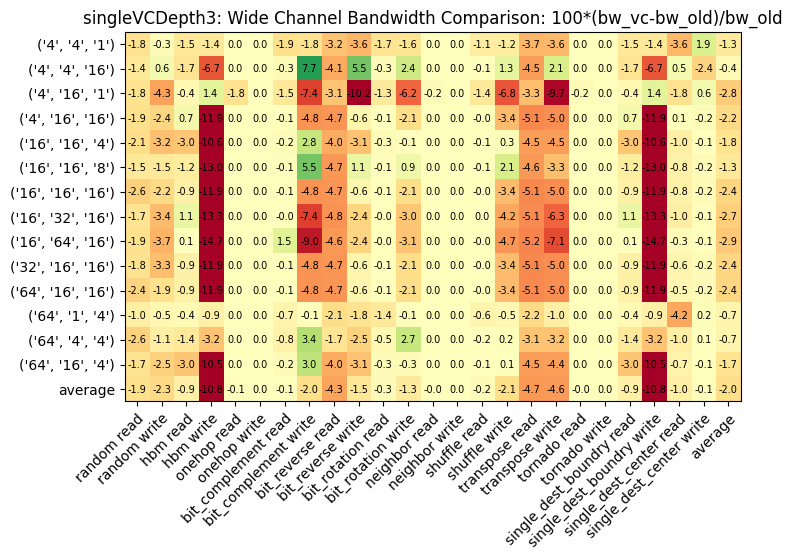

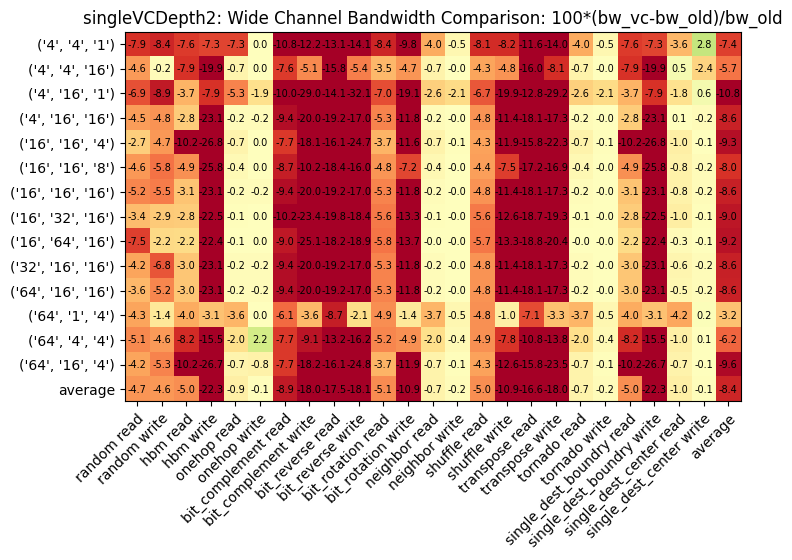

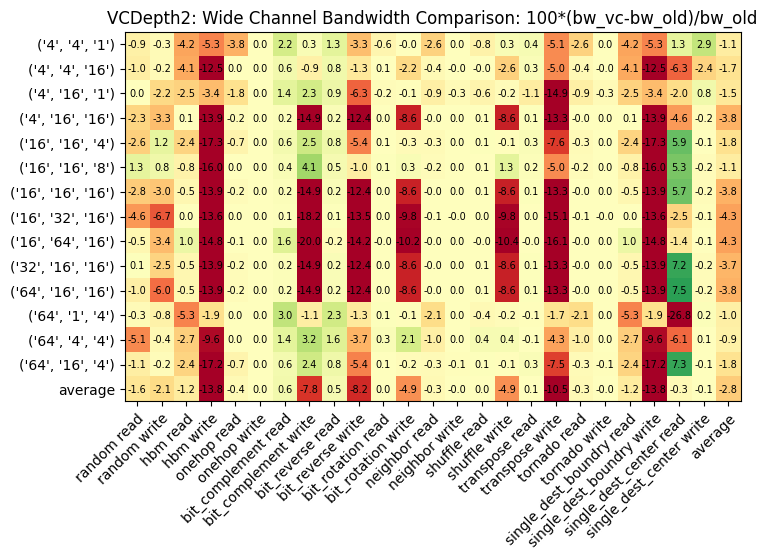

In [6]:
slow = 0      # 0 for fast, 1 for slow slave
bandwidth = 1 # 0 for latency, 1 for bandwidth
experiment_addon = "slowSlave" if slow else ""
for experiment in ("singleVCDepth3","singleVCDepth2","VCDepth2", "VCDepth3", "VCd2Whd3NoOverflow", "VCd2Whd3WithOverflow", "VCd2Whd3WithOverflowVCL1"):
    try:
        data, traffic_types, parameter_combinations = get_data(experiment_addon + experiment)
        plot_data(data, traffic_types, parameter_combinations, experiment_addon + experiment, bandwidth)
    except FileNotFoundError:
        print(f"File not found: output/dma_experiments_{experiment_addon + experiment}.txt")
        continue

In [ ]:
slow = 0      # 0 for fast, 1 for slow slave
bandwidth = 0 # 0 for latency, 1 for bandwidth
experiment_addon = "slowSlave" if slow else ""
for experiment in ("singleVCDepth3","singleVCDepth2","VCDepth2", "VCDepth3", "VCd2Whd3NoOverflow", "VCd2Whd3WithOverflow", "VCd2Whd3WithOverflowVCL1"):
    try:
        data, traffic_types, parameter_combinations = get_data(experiment_addon + experiment)
        plot_data(data, traffic_types, parameter_combinations, experiment_addon + experiment, bandwidth)
    except FileNotFoundError:
        print(f"File not found: output/dma_experiments_{experiment_addon + experiment}.txt")
        continue